Parse the original data

In [1]:
import pandas as pd

df = pd.read_csv("../wall/_src/SPR45_2D_Wall.csv", skiprows=1)
wall_R_m = df["R [mm]"] * 1e-3
wall_Z_m = df["Z [mm]"] * 1e-3
upper_dome_R_m = df["R [mm].1"] * 1e-3
upper_dome_Z_m = df["Z [mm].1"] * 1e-3
lower_dome_R_m = df["R [mm].2"] * 1e-3
lower_dome_Z_m = df["Z [mm].2"] * 1e-3

Join the domes to the wall

In [2]:
import numpy as np

lower_dome_mask = ~np.isnan(lower_dome_Z_m)
lower_dome_Z_m_open = lower_dome_Z_m.values[lower_dome_mask][:-1]
lower_dome_R_m_open = lower_dome_R_m.values[lower_dome_mask][:-1]

upper_dome_mask = ~np.isnan(upper_dome_Z_m)
upper_dome_Z_m_open = upper_dome_Z_m.values[upper_dome_mask][:-1]
upper_dome_R_m_open = upper_dome_R_m.values[upper_dome_mask][:-1]

wall_R_m_with_baffles = np.hstack(
    [
        wall_R_m[:7],
        lower_dome_R_m_open,
        wall_R_m[7:364],
        upper_dome_R_m_open[::-1],
        wall_R_m[364:],
    ]
)
wall_Z_m_with_baffles = np.hstack(
    [
        wall_Z_m[:7],
        lower_dome_Z_m_open,
        wall_Z_m[7:364],
        upper_dome_Z_m_open,
        wall_Z_m[364:],
    ]
)

Sanity check plot

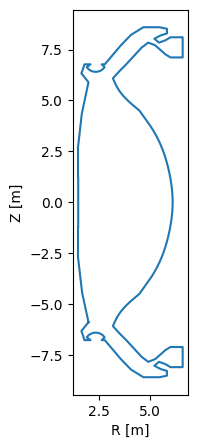

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 5))
plt.plot(wall_R_m_with_baffles, wall_Z_m_with_baffles)
plt.gca().set_aspect("equal")
plt.ylabel("Z [m]")
plt.xlabel("R [m]")
plt.savefig("wall.png", dpi=1000)

Convert to IMAS

In [4]:
import imas

ids_factory = imas.IDSFactory()
wall_ids = ids_factory.wall()
wall_ids.ids_properties.comment = "Generated from https://simdb.step.ukaea.uk/alias/shenders/SPR452DWall. Does not contain X-point"
wall_ids.ids_properties.homogeneous_time = imas.ids_defs.IDS_TIME_MODE_INDEPENDENT

wall_ids.description_2d.resize(1)

# Save the first wall only
wall_ids.description_2d[0].limiter.type.index = 0
wall_ids.description_2d[0].limiter.unit.resize(1)
wall_ids.description_2d[0].limiter.unit[0].name = "first_wall"
wall_ids.description_2d[0].limiter.unit[0].component_type.index = 5
wall_ids.description_2d[0].limiter.unit[0].outline.r = wall_R_m.values
wall_ids.description_2d[0].limiter.unit[0].outline.z = wall_Z_m.values

with imas.DBEntry("../wall/STEP_SPP_001_wall.nc", "w") as dbentry:
    dbentry.put(wall_ids)

16:12:57 CRITICAL Could not import 'imas_core': No module named 'imas_core'. Some functionality is not available. @imas_interface.py:34
16:12:57 INFO     Parsing data dictionary version 4.0.0 @dd_zip.py:89
